# All-pole model prior $p(x,y)$

**Note:** The AP model should be considered *a special case* of the PZ model where the amplitudes $c$ are chosen in a very special way, and a rescaling parameter $g$ is introduced. In the PZ model the rescaling parameter is directly implicit in the complex amplitudes $c$.

## Model

Impulse response for $K$ poles $p_k = -\pi y_k + 2\pi i x_k$:

$$ h(t; p, g) = (t \geq 0) \times \sum_{k=1}^K c_k e^{p_k t} + c_k^* e^{p_k^* t}$$

Now each coefficient is not a free parameter, but immediately determined by the poles $p$ and the *gain* parameter $g$. They are determined by the special case that the numerator of the PZ degenerates to zero-th order polynomial in $x$. In other words, the transfer function can be written:

$$ \tilde{h}(x; p, g) \propto {1 \over \prod_{k=1}^K (2\pi i x - p_k)(2\pi i x - p_k^*)}$$

This still needs rescaling: the units don't make sense (it must have units of time -- **we use msec in our code**), and we know that the energy $\mathcal{E}(p, g) = \int h(t; p, g)^2 dt$ must be O(1) msec.

The normal procedure is to normalize using the pole product $N_p = \prod_{k=1}^K |p_k|^2$ such that the gain $|\tilde{h}(0; p, g)| = 1$ at DC, see e.g. Fulop 2011. But note that this is dimensionally inconsistent (it is unitless while it should have units of time (inverse Hz)), and does not constrain $\mathcal{E}(p, g)$ in the way we want (in fact it will be too large). So, taking these hints seriously, we introduce the "extra" gain parameter $g$ such that the transfer function satisfies $\tilde{h}(0; p, g) = g$ (that's why we call it the gain). The full expression is therefore:

$$ \tilde{h}(x; p, g) = {g N_p \over \prod_{k=1}^K (2\pi i x - p_k)(2\pi i x - p_k^*)}$$

From this it follows immediately the expression for the $c_k$ coefficients using partial fraction expansions. Here we use the "excluded pole product"

$$ c_k = \lim_{x \rightarrow p_k} (x - p_k) \tilde{h}(x; p, g) = {g N_p  \over \prod (p_k - p_1) (p_k - p_1^*) \ldots (p_k - p_k^*) \ldots (p_k - p_K) (p_k - p_K^*)} $$

Note that this is indeed dimensionless, as it should be.

See @Arfken2005 for a reference on partial fraction expansions (PFEs). We
simply use the limit formula.

In [1]:
%run init.ipy

from vtr.prior import bandwidth
from dgf import core
from lib import constants
from vtr.prior import allpole
from vtr import spectrum

2022-12-06 16:57:35.825071: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-06 16:57:35.825165: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-06 16:57:35.825174: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## The prior for $g$: $p(g|p,E)$

We want to constrain $g$ such that the energy if the impulse response $\mathcal{E}(p, g) = \int h(t; p, g)^2 dt$ is equal to $E$ = O(1) msec.

We can reuse the analytic expression for $\mathcal{E}$ from the PZ model, since the AP model is just a special case of the PZ model:

$$ \mathcal{E}(p, g) = \sum_{ij=1}^{2K} \alpha_i \alpha_j S_{ij} := E$$

Since $\alpha_i \propto g$, this is quadratic in $g$. In other words, define $S(p)$ as

$$ \mathcal{E}(p, g) \equiv g^2 S(p)$$

where $S(p)$ only depends on the poles $p$ and has units [frequency]. Now the ME problem to be solved is trivial:

*Find $p(g|p,E)$ s.t. $$<\mathcal{E}> = \int dg\ \mathcal{E} p(g|p,E) = \int dg\ [g^2 S(p)] p(g|p,E) := E$$*

The solution is

$$ p(g|p,E) = N(0, \sigma_g^2)$$

where $\sigma_g^2 = E/S(p)$ which has units of [time/frequency] = [time²].

Note that the ME formalism does not imply that $h > 0$; $h \in \mathbb{R}$. So next to fixing the proper scale, and fixing the units, we also have gained an overall freedom in the polarity of the phase response by introducing $g$.

(And indeed, contrary to ME, we also tried a prior on $g^2 > 0$ which is $Exp(S_p/E)$, but it is actually less good as judged by $\log Z$ and the information $H$).

Just like the PZ case, we simply fix $E = 1\ msec$ and get good results. The convolution with samples generated from our source DGF prior are indeed O(1) in peak amplitude.

In [8]:
def samplexy(K = 3, prior = bandwidth.TFB_prior()):
    T, *xy = prior.sample(seed=jaxkey())
    x, y = np.split(np.array(xy), 2)
    x, y = x[:K], y[:K]
    return x, y

[Memory]1672.8s, 27.9min: Loading get_vtrformants_training_data...
[Memory]1673.2s, 27.9min: Loading run_nested...
[Memory]1673.6s, 27.9min: Loading run_nested...


energy [msec] = (5.303325285932842, 5.303327638540989)


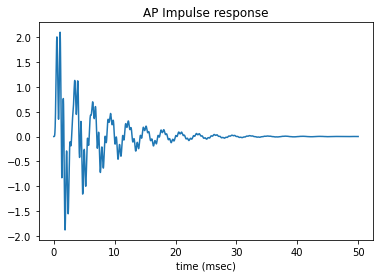

In [19]:
K = 3
x, y = samplexy(K)

fs = 1000 # kHz
dt = 1/fs # msec
t = np.arange(0., 50, dt) # msec

vtfilter = allpole.AllPoleFilter(K)
w = vtfilter.randw()

h = vtfilter.impulse_response(t, x, y, w)
plot(t, h)
title("AP Impulse response")
xlabel("time (msec)")

# Calculate energy numerically and compare with analytical result
energy = np.dot(h, h)*dt
print("energy [msec] =", (energy, vtfilter.impulse_response_energy(x, y, w)))

In [29]:
vtfilter.pole_coefficients(x, y, w)

array([ 0.00508582+0.62187922j,  0.00069734-0.40699623j,
       -0.00578316+0.20118921j])

Test if the expected values $<\mathcal{E}>$ is close to its prescribed value $E = 1\ msec$. There is a larger spread compared to PZ model, and much more mass on small values of $g$. They both look like Gamma distributions.

(0.9977681896803726, 1.419239657899917)

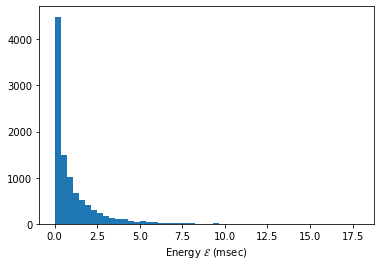

In [20]:
energies = []
for _ in range(10000):
    w = vtfilter.randw()
    energies += [vtfilter.impulse_response_energy(x, y, w)]

hist(energies, bins=50)
xlabel("Energy $\mathcal{E}$ (msec)")
mean(energies), std(energies) # msec

## The AP power spectrum

We compared with Scipy and it is the same.

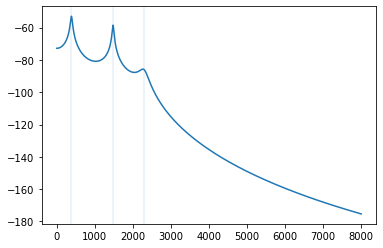

In [32]:
K = 3
vtfilter = allpole.AllPoleFilter(K)
x, y = samplexy()
w = vtfilter.randw()

f = constants.spectrum_frequencies(constants.TIMIT_FS_HZ)
power = vtfilter.transfer_function_power_dB(f, x, y, w)
plot(f, power, label="our implementation")
for xi in x: axvline(xi, alpha=.1)

### AP model as a special case of PZ

The PZ model includes the AP model as a special case, when the amplitudes $(a,b)$ take on specific values. The spectral tilt is then much lower than the usual -6 dB/oct (for large $x$).

In [ ]:
## Cross-chcek the allpole and polezero codes
## They must yield the same results at the PZ -> AP point
from vtr.prior import polezero

K = 3
x, y = samplexy(K)
g = allpole.g_prior_ppf(rand(), x, y)

# Calculate the amplitudes `ab_AP` that turn the PZ into an AP
c = allpole.pole_coefficients(x, y, g)
ab_AP = polezero.amplitudes(c) # convert to (cos, sin) real amplitudes
print(ab_AP)

# Plot the transfer functions and verify that they're equal
power = polezero.transfer_function_power_dB(f, x, y, ab_AP)
plot(f, power, label="PZ")
for xi in x: axvline(xi, alpha=.1)

plot(f, allpole.transfer_function_power_dB(f, x, y, g), '--', label="AP")
legend()
title("Power spectrum of an degenerated PZ-into-AP model")

# Fit tilt
F3 = x[-1]
tilt, interp = spectrum.fit_tilt(f, power, return_interp=True, cutoff=F3)
plot(f[f>F3], interp(f[f>F3]))
tilt

But does the $p(a,b|p,E)$ prior place any mass at that specific point? **Yes!** This is totally by virtue of the $g$ parameter, because it scales the $(a, b)$ amplitudes back "into reach" of the typical set of $p(a,b|p,\mu^2)$.

In [ ]:
# Visualize the "AP" point of the PZ amplitudes given the poles
import corner
import itertools

K = 3
x, y = samplexy(K)
g = allpole.g_prior_ppf(rand(), x, y)
c = allpole.pole_coefficients(x, y, g)
ab_AP = polezero.amplitudes(c) # convert to (cos, sin) real amplitudes

ab_samples = polezero.amplitudes_prior_ppf(rand(2*K, 1000), x, y).T

corner.corner(
    ab_samples,
    #range = itertools.repeat((-5, 5), 2*K),
    labels = [*["a"]*K, *["b"]*K],
    smooth = 1.,
    truths = ab_AP
);

This suggests that the PZ model, while nominally limited to -6 dB/oct tilt for large $x$, can actually model a range of spectral tilts within $[0, f_s/2]$, since it can model (i.e. its amplitudes have non-neglible mass at) produce the -36 dB/octave tilt characteristic of the AP. And indeed, this is confirmed in the next plot (note that the tilt measurement is +/- 6 dB accuracy).

In [ ]:
%%time
tilts = []

K = 3
f = constants.spectrum_frequencies(constants.TIMIT_FS_HZ)

for i in range(5000):
    x, y = samplexy()
    ab = polezero.amplitudes_prior_ppf(rand(2*K), x, y)
    power = polezero.transfer_function_power_dB(f, x, y, ab)
    
    F, B = spectrum.get_formants_from_spectrum(f, power)
    tilts += [spectrum.fit_tilt(f, power, cutoff=F[-1])]

hist(tilts, bins=50);
axvline(polezero.analytical_tilt(), color="green", label="theoretical tilt of PZ(3) model")
axvline(allpole.analytical_tilt(3), color="red", label="theoretical tilt of AP(3) model")
title("Spectral tilt distribution generated by$ p(a,b|p,mu^2)$ for a 3-pole PZ model")
xlabel("spectral tilt (dB/oct)")
legend();
mean(tilts)

### Using the information $H$ to quantify the use of the $g$ parameter

Yet another way of looking at this is quantifying how much the constraint $\alpha = (a, b) \rightarrow \alpha_{AP} = (a_{AP}, b_{AP})$ is worth in terms of information. This can be done by simply calculating the standard KL divergence between the 2 multivariate Gaussians:

$$ D_{KL}(\delta(\alpha - \alpha_{AP})|N(\alpha|0, \Sigma)) = \infty $$

Here $\Sigma = {E \over 2K} S(p)^{-1}$ (see polezero.ipynb).

So in practice we relax the problem (like we did in calculating the density $p(u)$) where we add a "tolerance" for the amplitudes, which determines our precision -- how close should an $\alpha \sim N(0, \Sigma)$ be to $\alpha_{AP}$ to be reckoned "close"?

Since we are directly in the amplitude domain, it is reasonable to take the noise floor power $\delta_n^2$ as the tolerance (in fact, the square root of it). So we relax the following way

$$ \delta(\alpha - \alpha_{AP}) \rightarrow N(\alpha|\alpha_{AP}, \delta_n^2 I_{2K}) $$

This yields an analytical formula for $D_{KL}(N_{AP}|N_{PZ})$.

The resulting distribution of $D_KL$'s for $x,y \sim p(F,B)$ and $g \sim p(g|p,E)$ are heavy-tailed, so we plot medians and IQRs for them. In general we see that
- The KL divergences in bans are perhaps a bit larger than hoped (given $\delta_n^2 = -60\ dB$, and since they grow linearly as $K$, finding the AP model in the PZ parameter space becomes rapidly impossible (at least at the given tolerance).
- The *difference* in KL divergence between an AP model *with* $g \sim p(g|p,E)$ and an AP model *without* $g$ (i.e. $g := 1$) are **independent** of $\delta^2_n$ and are enormous. So here is yet another reason why $g$ is extremely important.

In [ ]:
%%time
# Very slow
from lib import util

def kldiv_AP_PZ(x, y, g, delta2, E_msec = 1.):
    E = len(x)
    E = E_msec/1000.
    S = polezero.overlap_matrix(x, y)
    precision_matrix = (2*K)/E*S
    
    c = allpole.pole_coefficients(x, y, g)
    ab_AP = polezero.amplitudes(c) # convert to (cos, sin) real amplitudes
    
    # Using an analytic formula, but this is just KL(MVN0, MVN1)
    KL_nats = 0.5*(\
        2*K/E*delta2*np.trace(S) +\
        2*K/E*ab_AP.T @ S @ ab_AP +\
        (-2*K) +\
        2*K*np.log(E/(2*K)) - np.linalg.slogdet(S)[1] - 2*K*np.log(delta2)
    )
    
    return util.nats_to_ban(KL_nats) # ban

nsamp = 50
Ks = (1, 2, 3)
delta2 = constants.NOISE_FLOOR_POWER
print("Tolerance (amplitude):", sqrt(delta2))

KLs = np.zeros((nsamp, len(Ks)))
KLs_noscaling = np.zeros((nsamp, len(Ks)))
    
for j, K in enumerate(Ks):
    for i in range(nsamp):
        x, y = samplexy(K)
        g = allpole.g_prior_ppf(rand(), x, y)

        KLs[i, j] = kldiv_AP_PZ(x, y, g, delta2)
        KLs_noscaling[i, j] = kldiv_AP_PZ(x, y, 1., delta2)
    
# Plot the bans for AP with g
errorbar(Ks, np.median(KLs, axis=0), scipy.stats.iqr(KLs, axis=0), label="With $g$ parameter")
legend()
xlabel("K")
xticks(Ks)
ylabel("information [ban]")
ylim(0, None)
title("Given tolerance $\delta_n^2$, how much mass does the PZ place at the AP point?\nOr: How many times do I need to sample PZ amplitude prior to get an AP model?");
show()

# Plot the difference in bans: how many times extra do we need to sample
# if we don't use g as an extra parameter?
# **This is independent of the tolerance delta²_n**
errorbar(Ks, np.median(KLs_noscaling - KLs, axis=0), scipy.stats.iqr(KLs_noscaling - KLs, axis=0), label="Difference between not having and having $g$ parameter")
legend()
xlabel("K")
xticks(Ks)
ylabel("information [ban]")
title("Independent of tolerance $\delta_n^2$: how much more do I need to sample PZ amplitude prior to get an AP model?");

## Fitting the TFB samples

In [33]:
%%time
samples = bandwidth.get_TFB_samples()

[Memory]3537.7s, 59.0min: Loading get_TFB_samples...
CPU times: user 33.6 ms, sys: 283 µs, total: 33.9 ms
Wall time: 33.6 ms


In [34]:
results, context = bandwidth.fit_TFB_sample(
    samples[0],
    allpole.AllPoleFilter(3),
    111111111105,
    return_full=True
)

________________________________________________________________________________
[Memory] Calling vtr.prior.bandwidth.run_nested...
run_nested(111111111105, {'bootstrap': 10, 'nlive': 18, 'sample': 'rslice'}, {'maxcall': 10000000, 'save_bounds': False})


426it [00:57,  7.38it/s, +18 | bound: 62 | nc: 1 | ncall: 21726 | eff(%):  2.045 | loglstar:   -inf < -0.858 <    inf | logz: -20.263 +/-    nan | dlogz:  0.001 >  0.027]      

______________________________________________________run_nested - 57.8s, 1.0min


Summary
nlive: 18
niter: 426
ncall: 21708
eff(%):  2.045
logz: -20.263 +/-  0.982


None

'Information (bans)'

7.376689261712248

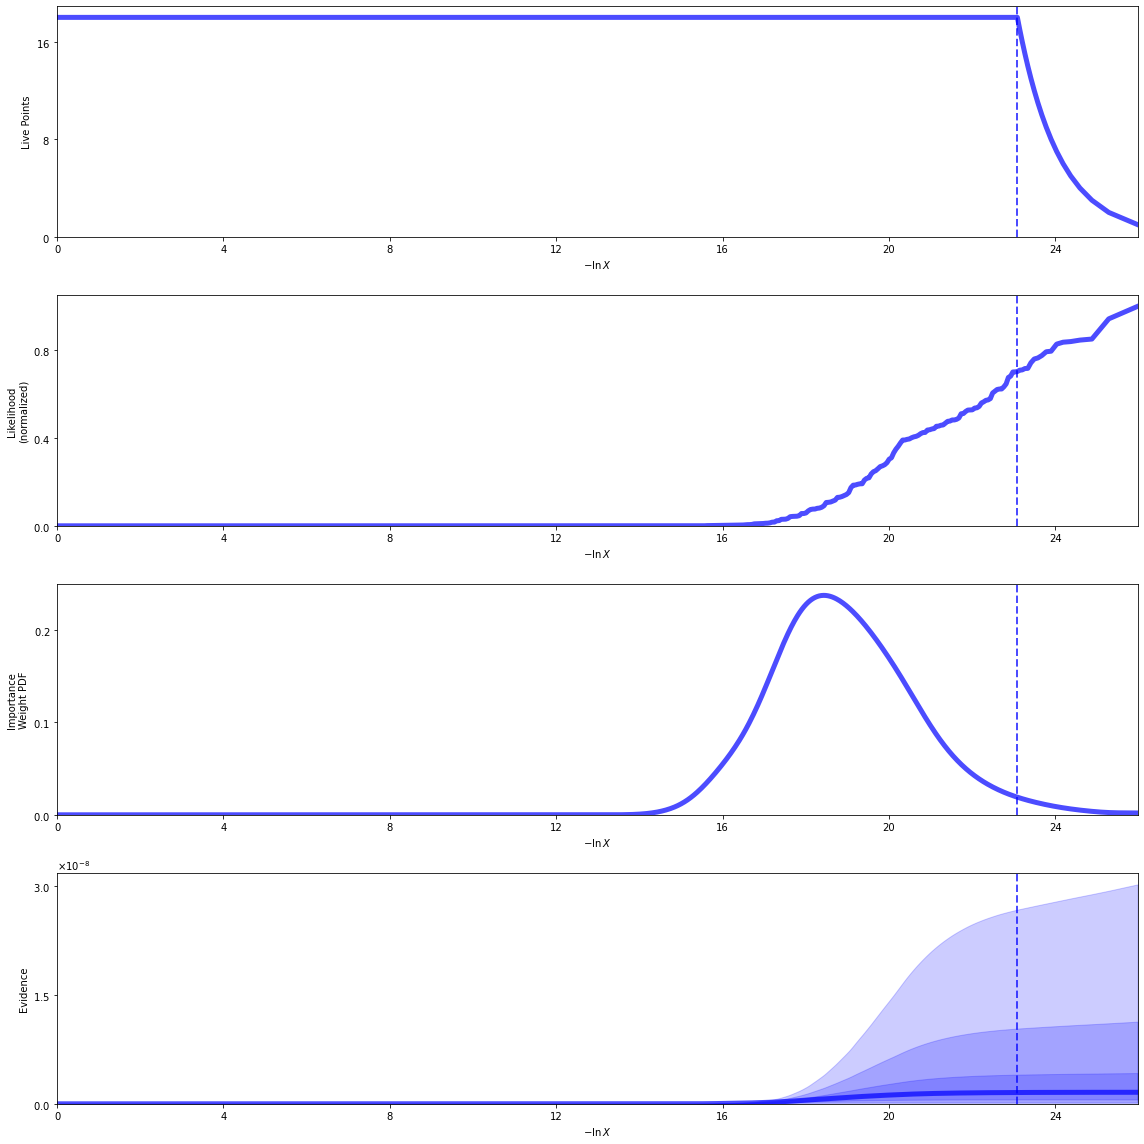

Quantiles:
$x_{1}$ [(0.025, 479.65883834103994), (0.5, 490.4595711546177), (0.975, 498.68407432884726)]
Quantiles:
$x_{2}$ [(0.025, 1216.5875701785892), (0.5, 1233.8386523001864), (0.975, 1254.766749082388)]
Quantiles:
$x_{3}$ [(0.025, 2400.328016951132), (0.5, 2427.6618826706053), (0.975, 2455.106357786463)]
Quantiles:
$y_{1}$ [(0.025, 55.479756832673125), (0.5, 71.3314490737534), (0.975, 84.39791699057687)]
Quantiles:
$y_{2}$ [(0.025, 20.754437768324077), (0.5, 41.58437309621359), (0.975, 73.5231839950829)]
Quantiles:
$y_{3}$ [(0.025, 134.1698912301281), (0.5, 194.2134318578542), (0.975, 252.1021194047286)]


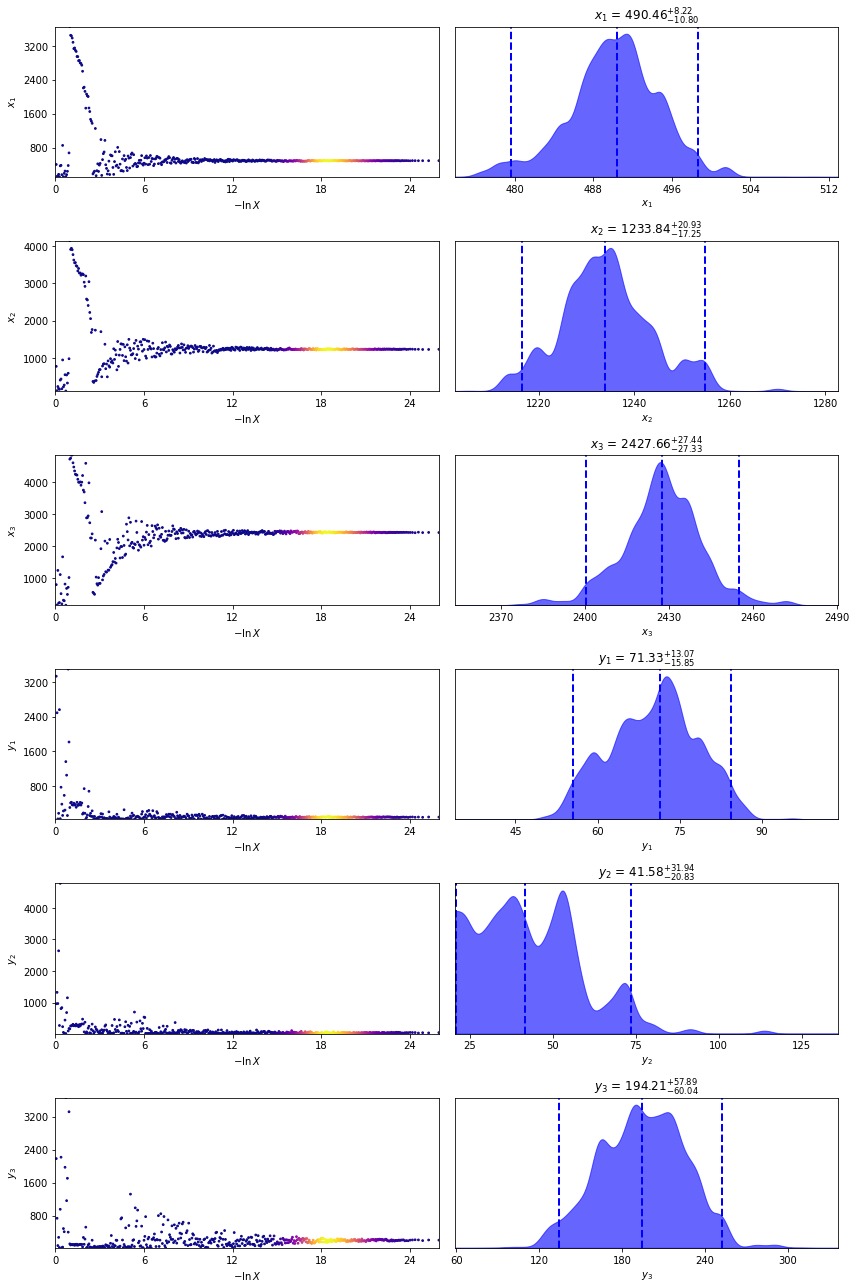

In [35]:
from lib import util

util.dyplot(results, context['dimlabels'], cornerplot=False)

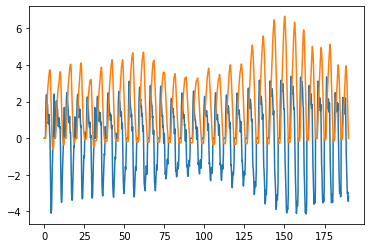

In [36]:
# Load an example DGF to convolve h(t) with
t, u = np.load("vtr/prior/dgf.npy")
plot(t, u)
plot(t, cumsum(u)*(t[1]-t[0]))

Num formants: 3
F vs F_true: [ 484. 1226. 2396.] [ 486.16 1233.88 2428.75]
B vs B_true: [ 35.32  14.32 150.36] [ 36.89  23.34 100.65]
Errors: 5.576096358641675 11.89443406565308 28.5626216909434
mu2(analytical) [msec] = 0.2448866762988569


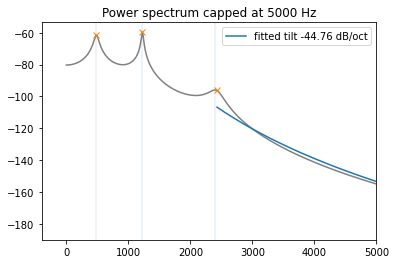

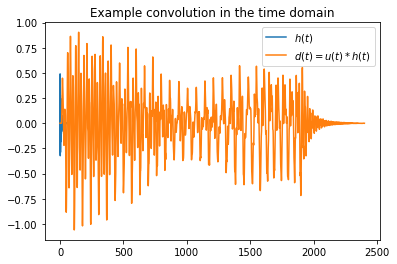

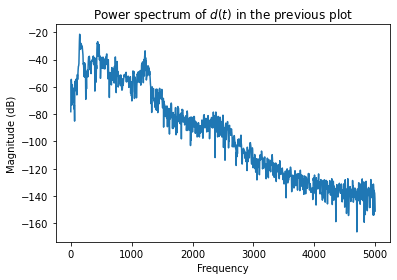

In [40]:
from IPython.display import Audio

def sample_posterior(results):
    return util.resample_equal(results, 1).squeeze()

def analyze(sample, context, w=None):
    x, y = context['unpack'](sample)
    
    vtfilter = context['vtfilter']
    if w is None:
        w = vtfilter.randw()

    f = context['f']
    power = vtfilter.transfer_function_power_dB(
        f, x, y, w
    )

    # Heuristically measure formants
    F, B = spectrum.get_formants_from_spectrum(f, power)

    # Heuristically measure spectral tilt starting from F3(true)
    cutoff = context['F_true'][-1]
    tilt, interp_tilt = spectrum.fit_tilt(f, power, cutoff=cutoff, return_interp=True)
    
    # Calculate impulse response energy (in msec)
    energy = vtfilter.impulse_response_energy(x, y, w)
    
    print("Num formants:", len(F))
    if len(F) == 3:
        F_err = np.sum(((F - context['F_true'])/context['sigma_F'])**2)
        B_err = np.sum(((B - context['B_true'])/context['sigma_B'])**2)
        print("F vs F_true:", np.round(F, 2), np.round(context['F_true'], 2))
        print("B vs B_true:", np.round(B, 2), np.round(context['B_true'], 2))
    else:
        F_err = inf
        B_err = inf
    
    tilt_err = ((tilt - context['tilt_target'])/context['sigma_tilt'])**2
    print("Errors:", F_err, B_err, tilt_err)
    print("mu2(analytical) [msec] =", energy)
    
    # Plot stuff
    power = vtfilter.transfer_function_power_dB(f, x, y, w)
    plot(f, power, "grey")
    plot(f[f>cutoff], interp_tilt(f[f>cutoff]), label=f"fitted tilt {round(tilt,2)} dB/oct")
    plot(x, np.interp(x, f, power), 'x')
    for Fi in F: axvline(Fi, alpha=.1)
    xlim(None, 5000);
    title("Power spectrum capped at 5000 Hz")
    legend()
    show()
    
    t, dt = np.linspace(0., 50, int(50*constants.FS_KHZ), retstep=True) # msec
    h = vtfilter.impulse_response(t, x, y, w)
    plot(t, h, label="$h(t)$")
    d = convolve(h, u)*dt
    plot(d, label="$d(t) = u(t) * h(t)$")
    title("Example convolution in the time domain")
    legend()
    show()
    
    magnitude_spectrum(d, Fs=constants.FS_HZ, scale='dB')
    title("Power spectrum of $d(t)$ in the previous plot")
    show()
    
    display(Audio(d, rate=constants.FS_HZ, autoplay=True))

analyze(sample_posterior(results), context)

In [ ]:
fitted = allpole.get_fitted_TFB_samples()

In [12]:
K = 10
sample_index = 40

def getfit(K, sample_index):
    return fitted[(K-3)*200+sample_index]

fit = getfit(K, sample_index)

sample = fit['sample']
results = fit['results']

Summary
nlive: 63
niter: 2854
ncall: 402601
eff(%):  0.725
logz: -158.479 +/-  0.815


None

'Information (bans)'

15.155078330940283

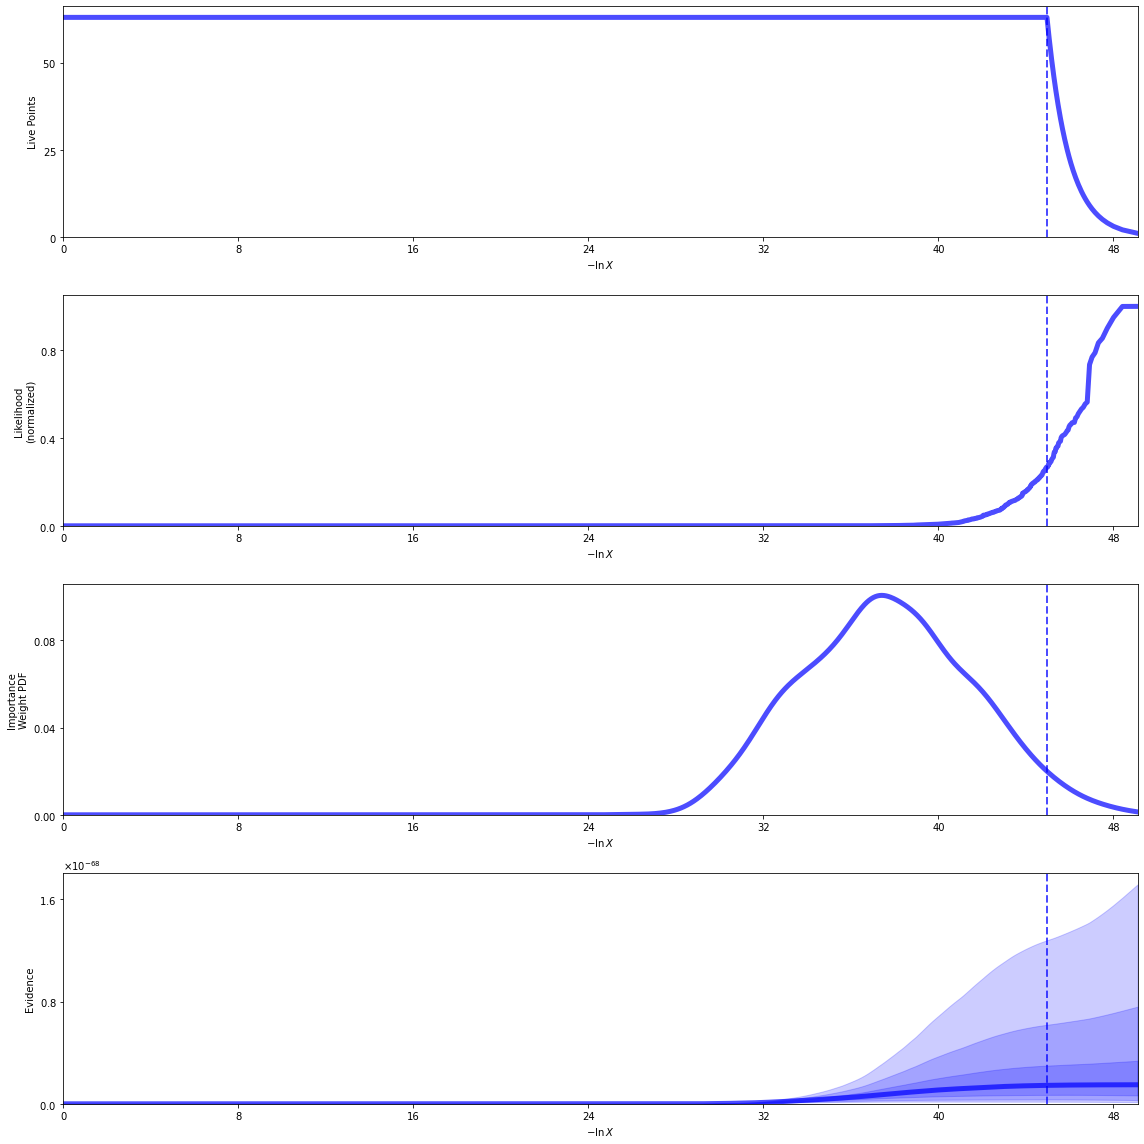

Quantiles:
x [(0.025, 198.5320459265199), (0.5, 228.55962256749106), (0.975, 256.5004765205055)]
Quantiles:
x [(0.025, 425.2202668533421), (0.5, 436.21772557475396), (0.975, 449.14063316137)]
Quantiles:
x [(0.025, 436.74041642706777), (0.5, 455.69646117521853), (0.975, 485.41206684925294)]
Quantiles:
x [(0.025, 1201.824524954116), (0.5, 1279.6842822111278), (0.975, 1377.4998513848632)]
Quantiles:
x [(0.025, 1374.1762571845388), (0.5, 1452.2025690707867), (0.975, 1516.4454162107386)]
Quantiles:
x [(0.025, 1731.2603701002326), (0.5, 1750.864529642413), (0.975, 1768.883424788812)]
Quantiles:
x [(0.025, 1880.4529970129727), (0.5, 1953.2304834561291), (0.975, 2061.817762015699)]
Quantiles:
x [(0.025, 2175.362727274138), (0.5, 2303.703971114473), (0.975, 2434.0903158452525)]
Quantiles:
x [(0.025, 2767.5395359767535), (0.5, 2910.2944478676504), (0.975, 3006.3756201672304)]
Quantiles:
x [(0.025, 3015.7628548916164), (0.5, 3046.9834008980433), (0.975, 3077.923583021323)]
Quantiles:
y [(0.025, 1

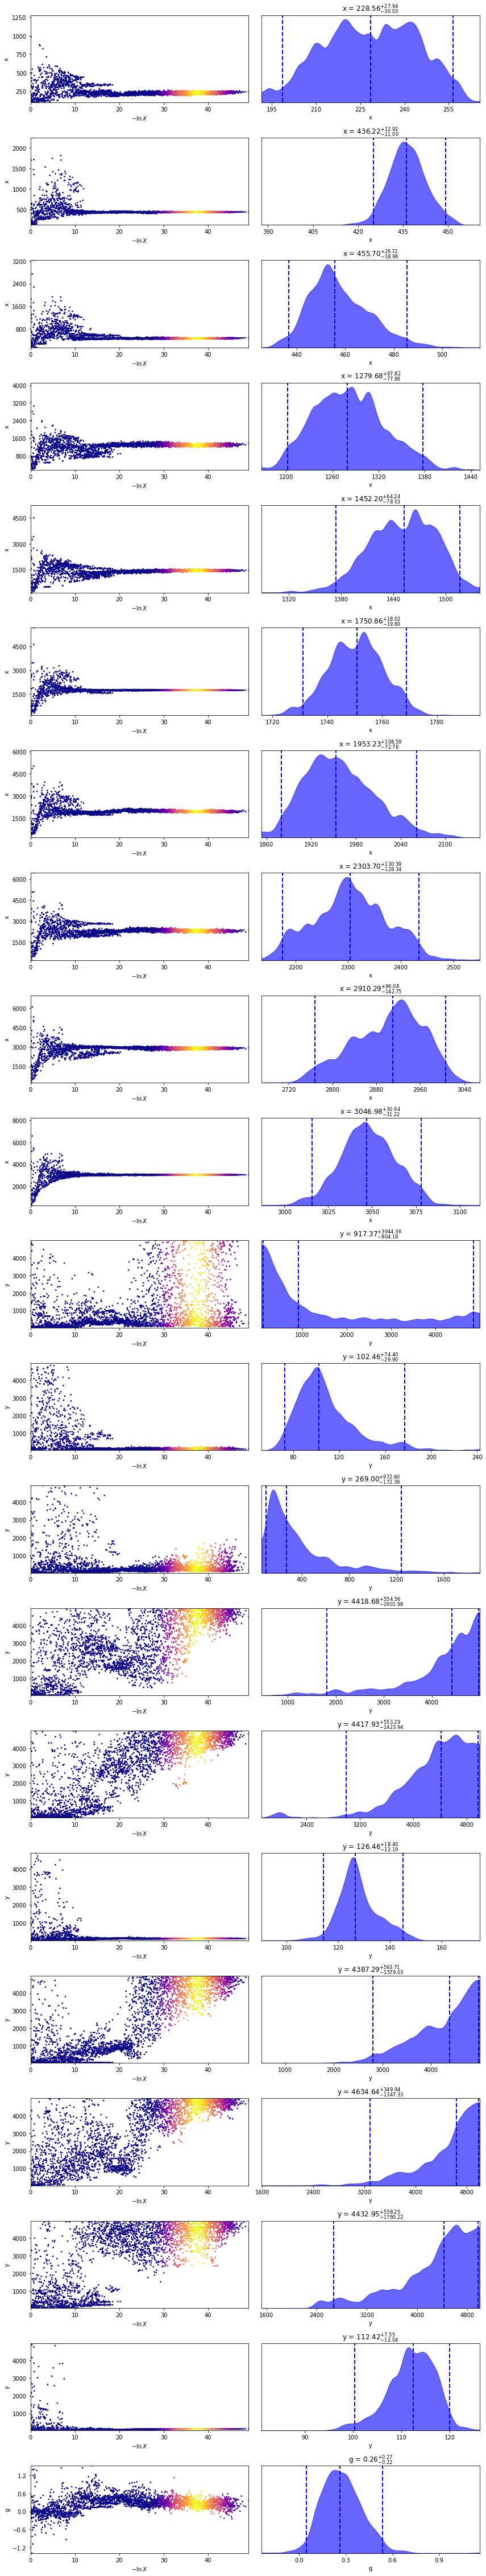

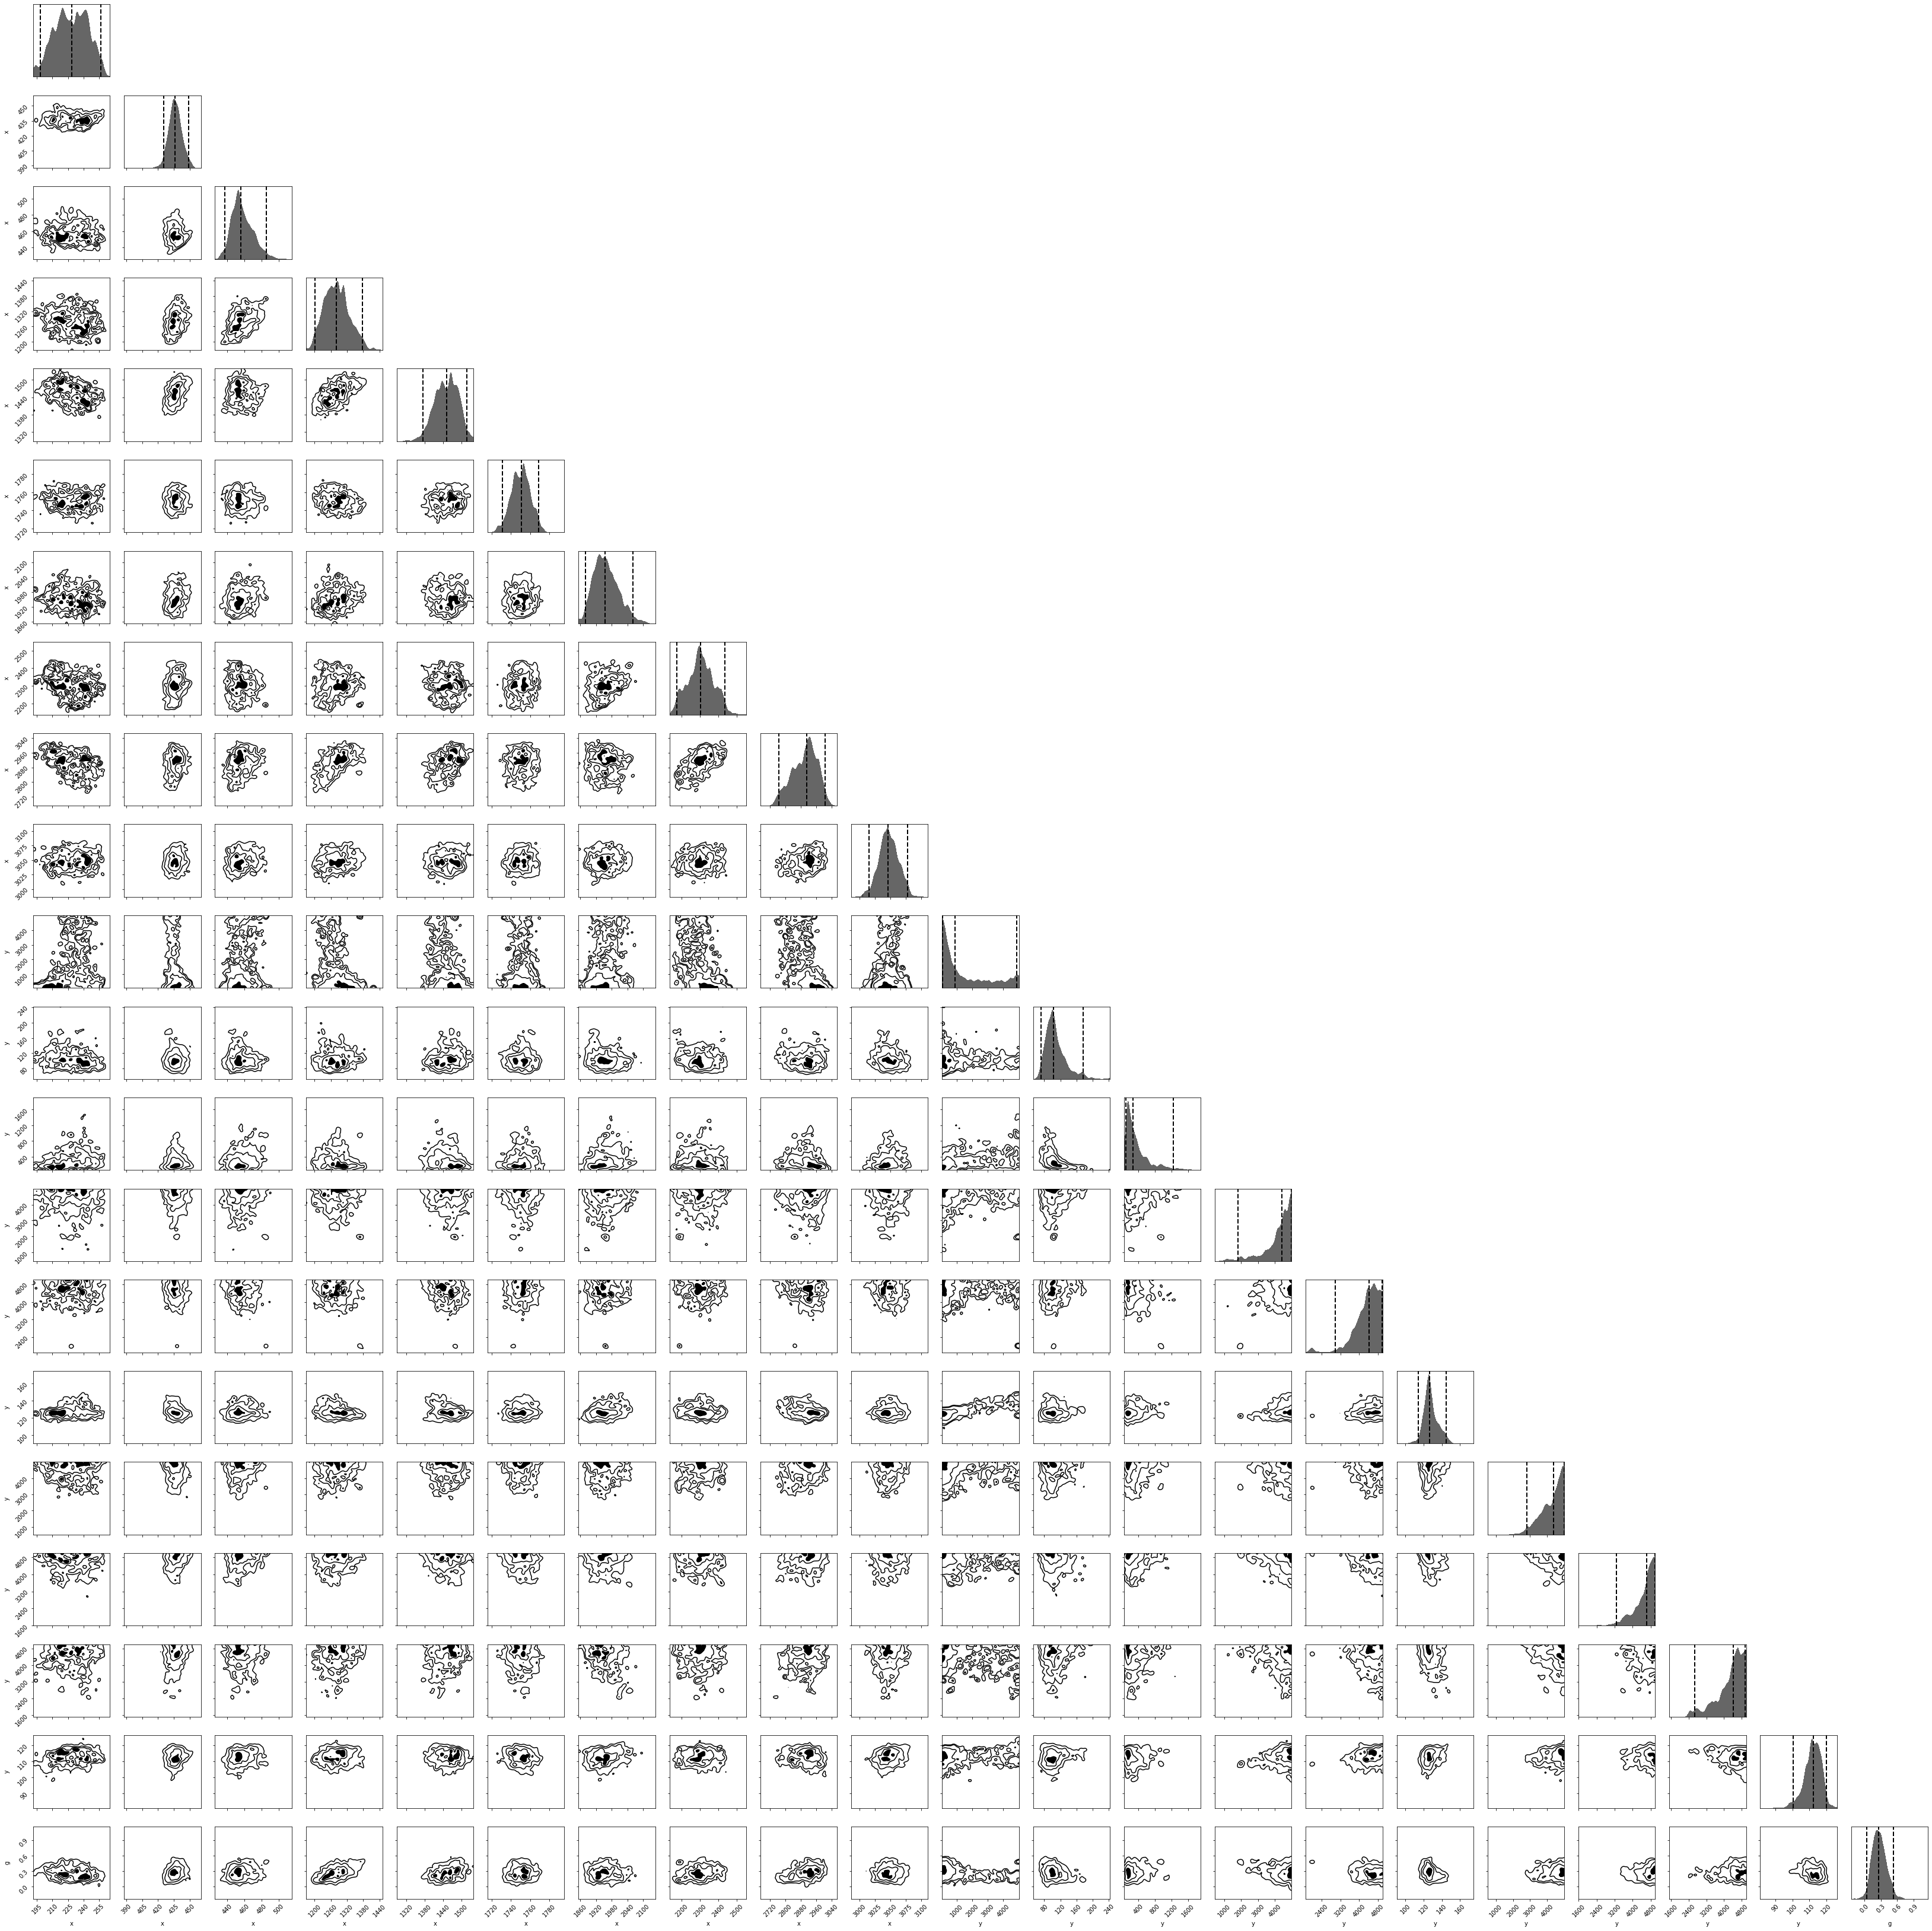

In [25]:
from lib import util

util.dyplot(results, (*["x"]*K, *["y"]*K, "g"), cornerplot=True); # (1.25, 1)

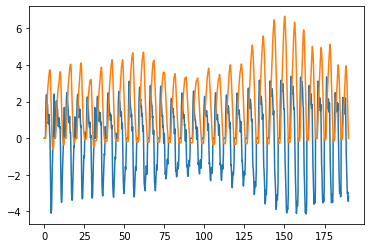

In [14]:
# Load an example DGF to convolve h(t) with
t, u = np.load("vtr/prior/dgf.npy")
plot(t, u)
plot(t, cumsum(u)*(t[1]-t[0]))

[ 430. 1714. 3024.] [ 430.63 1735.34 3038.25]
[46.76 89.6  75.38] [ 46.36  95.18 128.47]
5.470972086259167 12.848221058685112 231.69701762540643 0.06360448568783923
mu2(analytical) [msec] = 0.7478007024438029


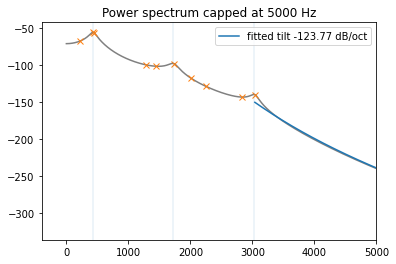

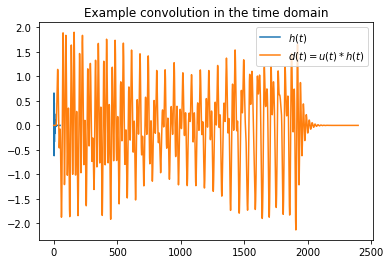

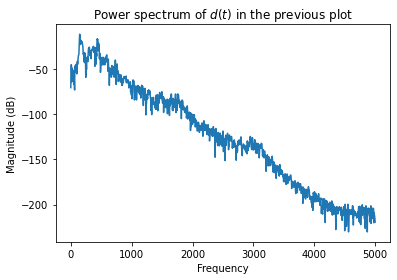

-125.03990762801928

In [15]:
from IPython.display import Audio
from vtr.prior.allpole import *

def unpack(params):
    x, y = np.split(params[:-1], 2)
    g = params[-1]
    return x, y, float(g)

def loglike_debug(
    params,
    f = sample['f'],
    F_true = sample['F'],
    B_true = sample['B'],
    sigma_F=constants.SIGMA_FB_REFERENCE_HZ,
    sigma_B=constants.SIGMA_FB_REFERENCE_HZ,
    tilt_target=constants.FILTER_SPECTRAL_TILT_DB,
    sigma_tilt=constants.SIGMA_TILT_DB,
    energy_target=constants.IMPULSE_RESPONSE_ENERGY_MSEC,
    sigma_energy=constants.SIGMA_IMPULSE_RESPONSE_ENERGY_MSEC
):
    x, y, g = unpack(params)
    
    # Calculate pole-zero transfer function
    power = transfer_function_power_dB(f, x, y, g)

    # Heuristically measure formants
    F, B = spectrum.get_formants_from_spectrum(f, power)

    # Heuristically measure spectral tilt starting from F3(true)
    cutoff = F_true[-1]
    tilt, interp_tilt = spectrum.fit_tilt(f, power, cutoff=cutoff, return_interp=True)
    
    # Calculate impulse response energy (in msec)
    energy = impulse_response_energy(x, y, g)
    
    F_err = np.sum(((F - F_true)/sigma_F)**2)
    B_err = np.sum(((B - B_true)/sigma_B)**2)
    tilt_err = ((tilt - tilt_target)/sigma_tilt)**2
    energy_err = ((energy - energy_target)/sigma_energy)**2
    
    # Print debug information
    print(np.round(F, 2), np.round(F_true, 2))
    print(np.round(B, 2), np.round(B_true, 2))
    print(F_err, B_err, tilt_err, energy_err)
    print("mu2(analytical) [msec] =", energy)
    
    # Plot stuff
    power = transfer_function_power_dB(f, x, y, g)
    plot(f, power, "grey")
    plot(f[f>cutoff], interp_tilt(f[f>cutoff]), label=f"fitted tilt {round(tilt,2)} dB/oct")
    plot(x, np.interp(x, f, power), 'x')
    for Fi in F: axvline(Fi, alpha=.1)
    xlim(None, 5000);
    title("Power spectrum capped at 5000 Hz")
    legend()
    show()
    
    t, dt = np.linspace(0., 50, int(50*constants.FS_KHZ), retstep=True) # msec
    h = allpole.impulse_response(t, x, y, g)
    plot(t, h, label="$h(t)$")
    d = convolve(h, u)*dt
    plot(d, label="$d(t) = u(t) * h(t)$")
    title("Example convolution in the time domain")
    legend()
    show()
    
    magnitude_spectrum(d, Fs=constants.FS_HZ, scale='dB')
    title("Power spectrum of $d(t)$ in the previous plot")
    show()
    
    display(Audio(d, rate=constants.FS_HZ, autoplay=True))
    
    return -(F_err + B_err + tilt_err + energy_err)/2

loglike_debug(util.resample_equal(results, 1).squeeze())
#loglike_debug(util.resample_equal(results, 1).squeeze())
#loglike_debug(util.resample_equal(results, 1).squeeze())

## Aggregate

In [66]:
def get_TFB_row(fit):
    row = np.concatenate((
        [fit['sample']['T']],
        fit['sample']['F'],
        fit['sample']['B']
    ))
    return row

def posterior_of_fitted_TFB_values(K, numsamples=50):
    def process():
        for fit in allpole.get_fitted_TFB_samples():
            if fit['K'] == K:
                row = get_TFB_row(fit)
                rows = np.repeat(row[None,:], numsamples, axis=0)
                samples = util.resample_equal(fit['results'], numsamples)
                yield np.column_stack((rows, samples))

    return np.vstack(list(process()))

In [102]:
Kpost = 6

post_samples = np.vstack(posterior_of_fitted_TFB_values(Kpost))

[Memory]16055.4s, 267.6min: Loading get_TFB_samples...
[Memory]16055.4s, 267.6min: Loading run_nested...
[Memory]16055.4s, 267.6min: Loading run_nested...
[Memory]16055.4s, 267.6min: Loading run_nested...
[Memory]16055.4s, 267.6min: Loading run_nested...
[Memory]16055.4s, 267.6min: Loading run_nested...
[Memory]16055.4s, 267.6min: Loading run_nested...
[Memory]16055.4s, 267.6min: Loading run_nested...
[Memory]16055.4s, 267.6min: Loading run_nested...
[Memory]16055.4s, 267.6min: Loading run_nested...
[Memory]16055.4s, 267.6min: Loading run_nested...
[Memory]16055.4s, 267.6min: Loading run_nested...
[Memory]16055.4s, 267.6min: Loading run_nested...
[Memory]16055.4s, 267.6min: Loading run_nested...
[Memory]16055.4s, 267.6min: Loading run_nested...
[Memory]16055.4s, 267.6min: Loading run_nested...
[Memory]16055.4s, 267.6min: Loading run_nested...
[Memory]16055.4s, 267.6min: Loading run_nested...
[Memory]16055.4s, 267.6min: Loading run_nested...
[Memory]16055.4s, 267.6min: Loading run_neste

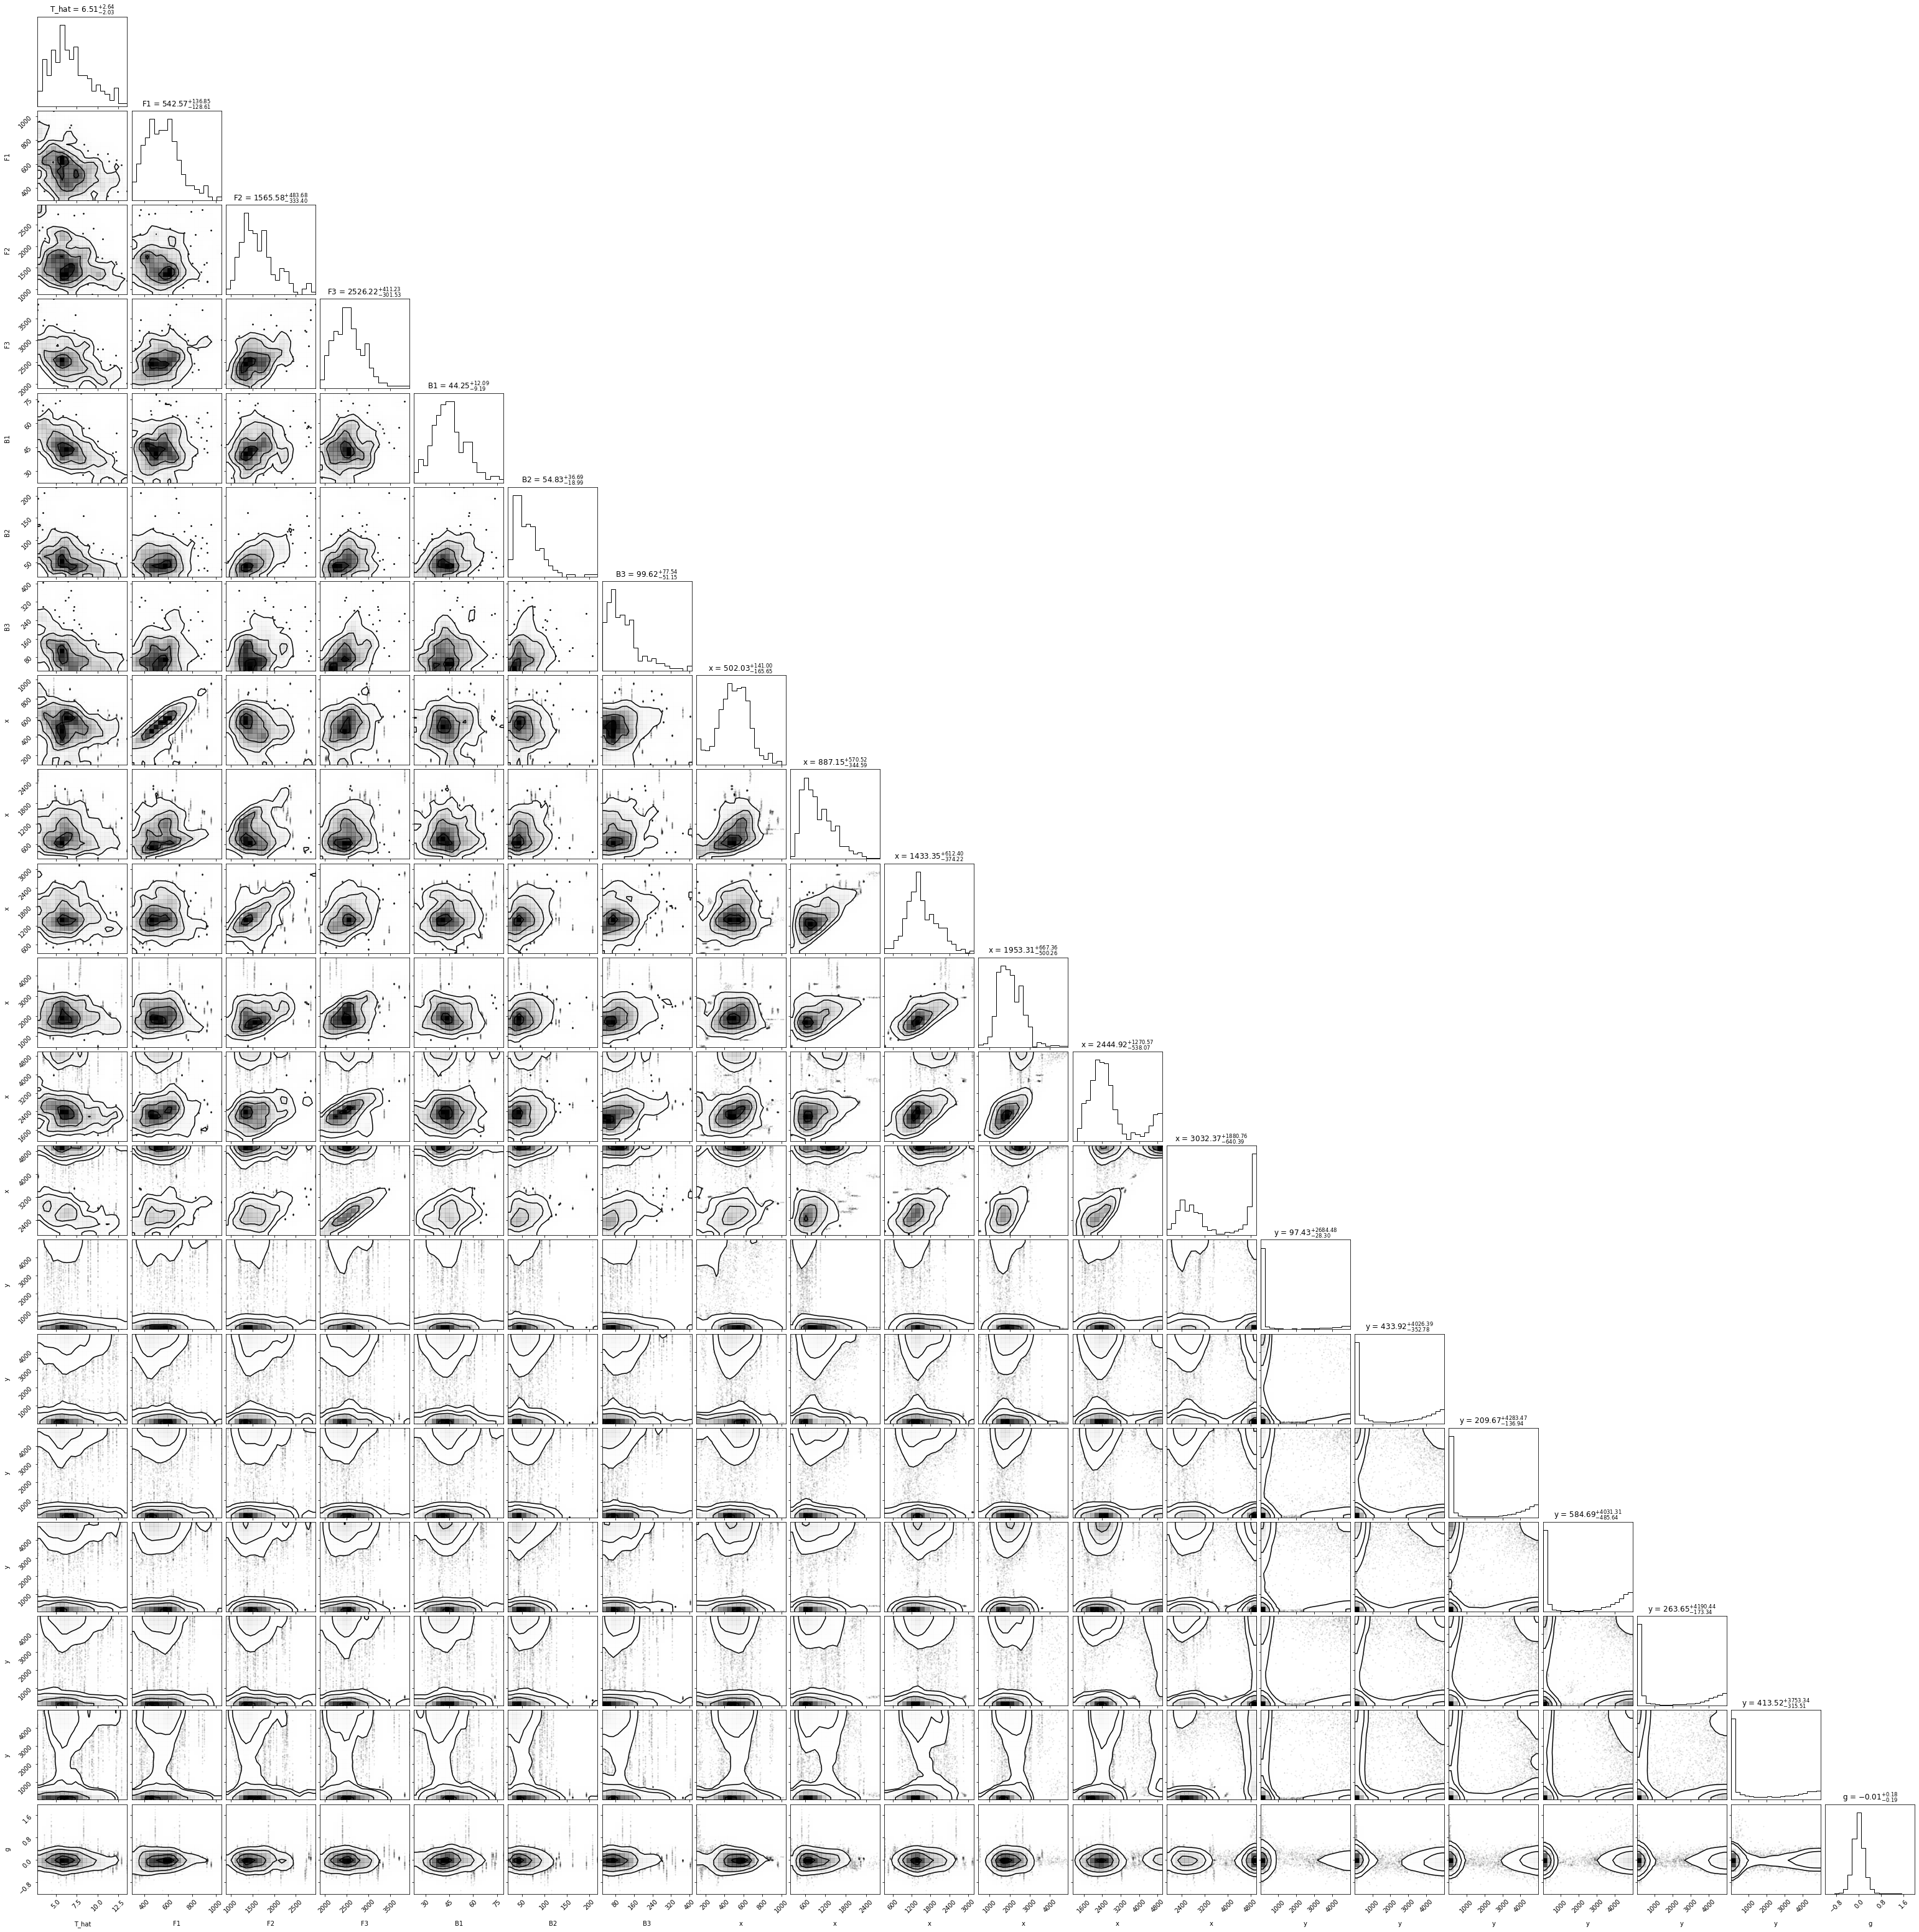

In [103]:
import corner

fig = corner.corner(
    post_samples,
    labels=(*bandwidth.TFB_NAMES, *["x"]*Kpost, *["y"]*Kpost, "g"),
    show_titles=True,
    smooth=1.
);

In [107]:
from dgf import bijectors

theta = post_samples[:,:-1]

post_bounds = np.array([
    [(100., 5000.)]*Kpost + [(20., 5000.)]*Kpost,
]).squeeze()

post_bounds = np.vstack((bandwidth.TFB_BOUNDS, post_bounds))

samplerargs = {'nlive': 3}

b, bresults = bijectors.fit_nonlinear_coloring_bijector(
    theta, post_bounds, 12345678900000000010,
    samplerargs=samplerargs, return_fit_results=True
)

________________________________________________________________________________
[Memory] Calling dgf.bijectors.run_nested...
run_nested(12345678900000000010, {'nlive': 3}, {'save_bounds': False})


/home/marnix/thesis/py/venv/lib/python3.10/site-packages/dynesty/dynesty.py:515: UserWarning: Beware! Having `nlive <= 2 * ndim` is extremely risky!
  warnings.warn("Beware! Having `nlive <= 2 * ndim` is extremely risky!")
148it [00:05, 25.21it/s, +3 | bound: 138 | nc: 1 | ncall: 5487 | eff(%):  2.753 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-  3.258 | dlogz:  0.003 >  0.012]

_______________________________________________________run_nested - 6.8s, 0.1min


Summary
nlive: 3
niter: 148
ncall: 5484
eff(%):  2.753
logz: -1974671.805 +/-  3.266


None

'Information (bans)'

16.02531837552545

/home/marnix/thesis/py/venv/lib/python3.10/site-packages/dynesty/plotting.py:315: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


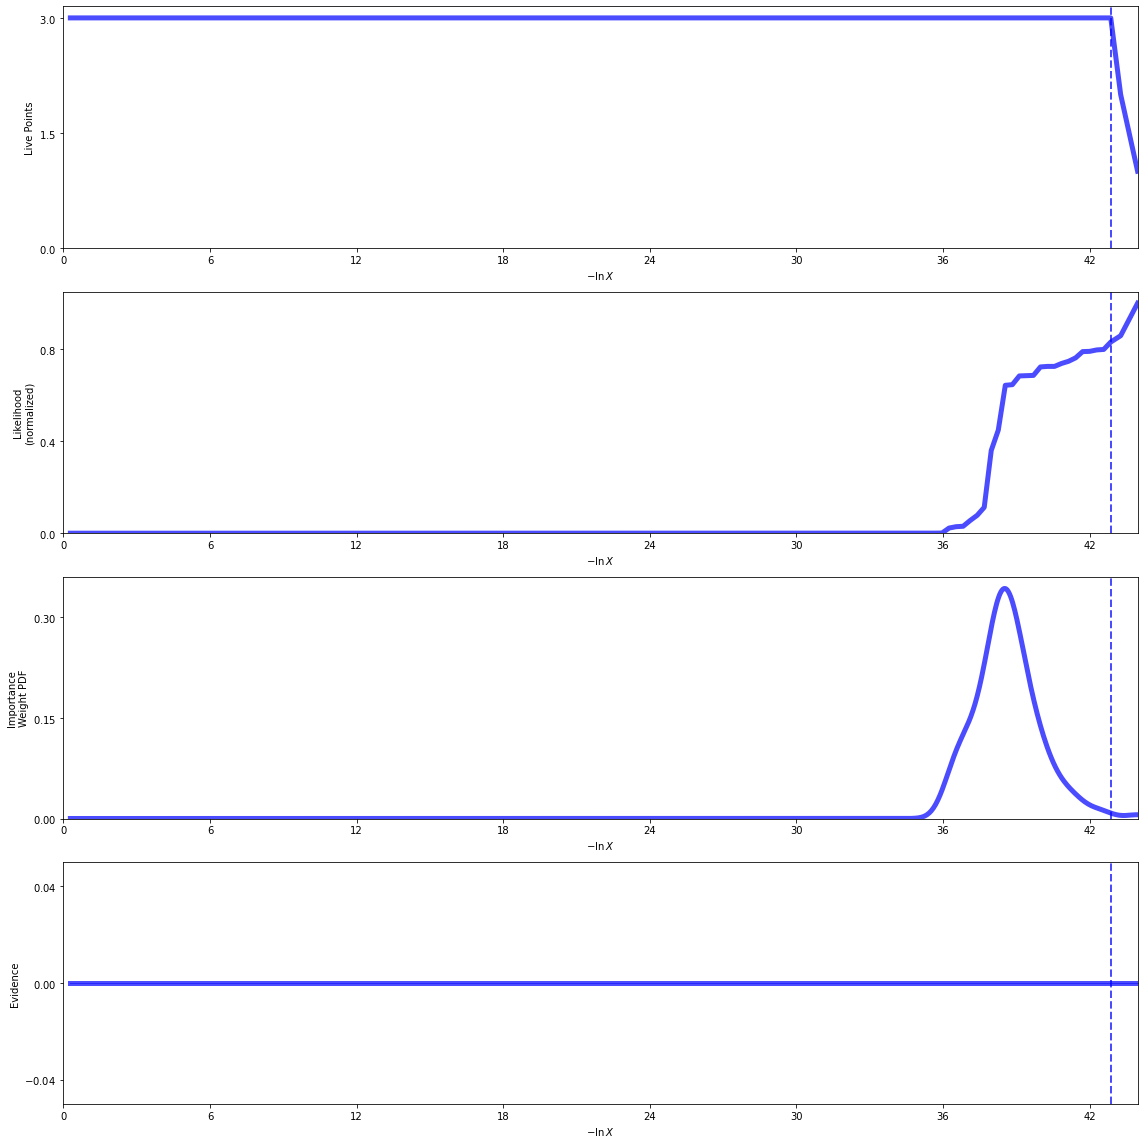

Quantiles:
$x_{1}$ [(0.025, 2.0792403345664665), (0.5, 2.080110974485595), (0.975, 2.081497013630427)]
Quantiles:
$x_{2}$ [(0.025, 0.8058299139049883), (0.5, 0.8061689189488849), (0.975, 0.8069575582094518)]
Quantiles:
$x_{3}$ [(0.025, 0.48243201439161076), (0.5, 0.48286275099755116), (0.975, 0.48342726500241856)]
Quantiles:
$x_{4}$ [(0.025, 1.4259244552477464), (0.5, 1.427201541082009), (0.975, 1.4292090510751503)]
Quantiles:
$x_{5}$ [(0.025, 0.9670290259181559), (0.5, 0.9672871304419484), (0.975, 0.9676983511750579)]
Quantiles:
$x_{6}$ [(0.025, 0.5881147185473048), (0.5, 0.5893823272834593), (0.975, 0.591372356921924)]
Quantiles:
$x_{7}$ [(0.025, 0.5858861978805496), (0.5, 0.5863145490352583), (0.975, 0.587609615667873)]
Quantiles:
$x_{8}$ [(0.025, 0.8353704319559699), (0.5, 0.8367097458639572), (0.975, 0.8381554942726714)]
Quantiles:
$x_{9}$ [(0.025, 1.2744298671708647), (0.5, 1.2751046023248247), (0.975, 1.2761315892077154)]
Quantiles:
$x_{10}$ [(0.025, 1.09872378531846), (0.5, 1.1

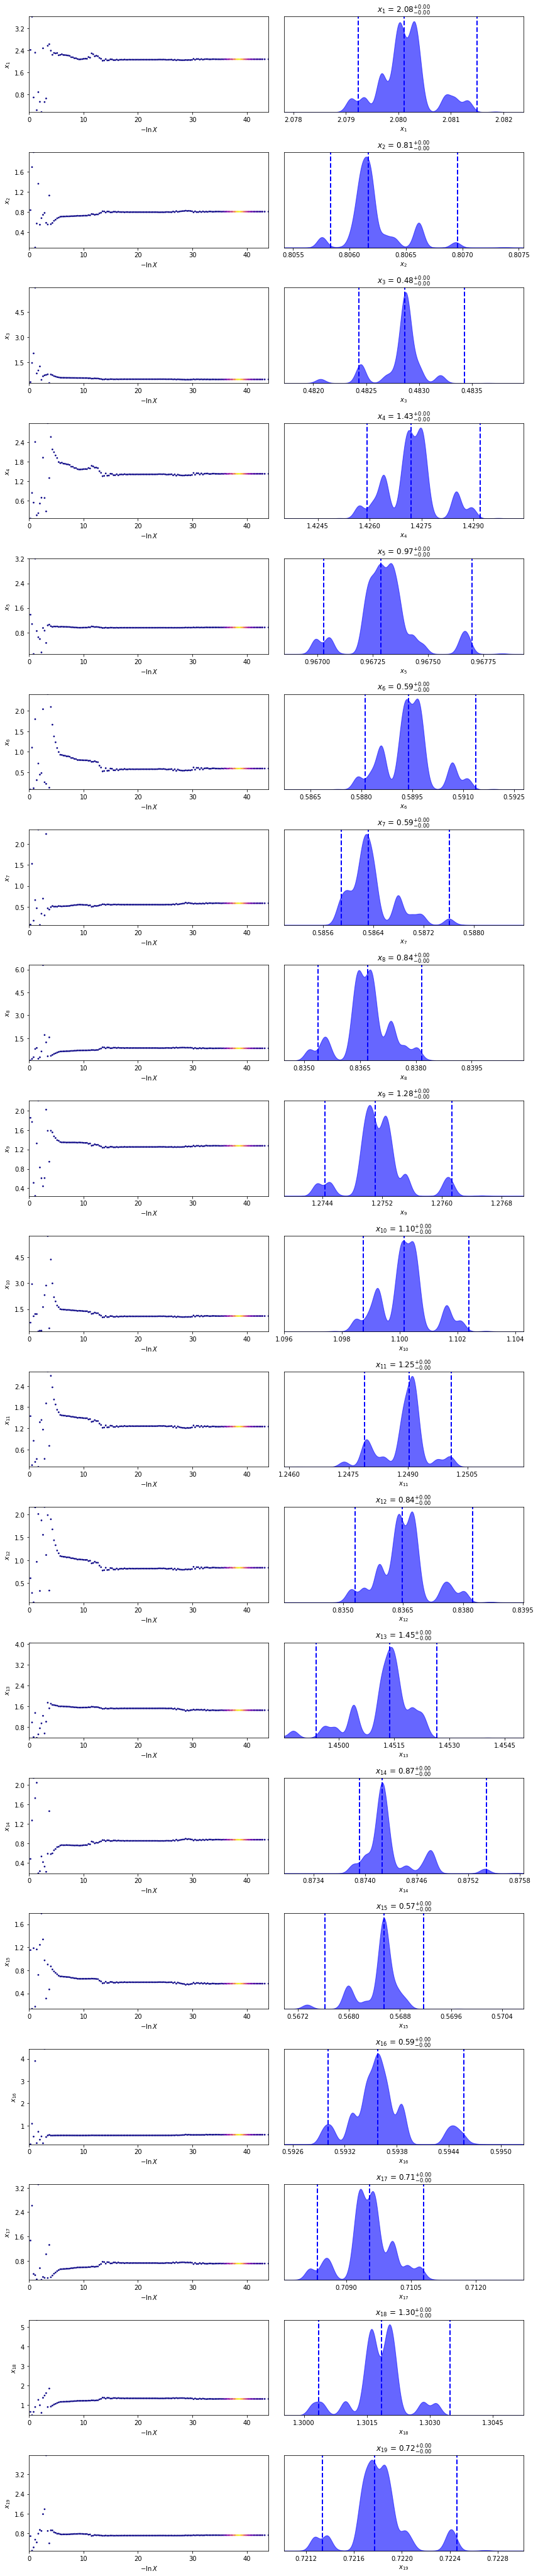

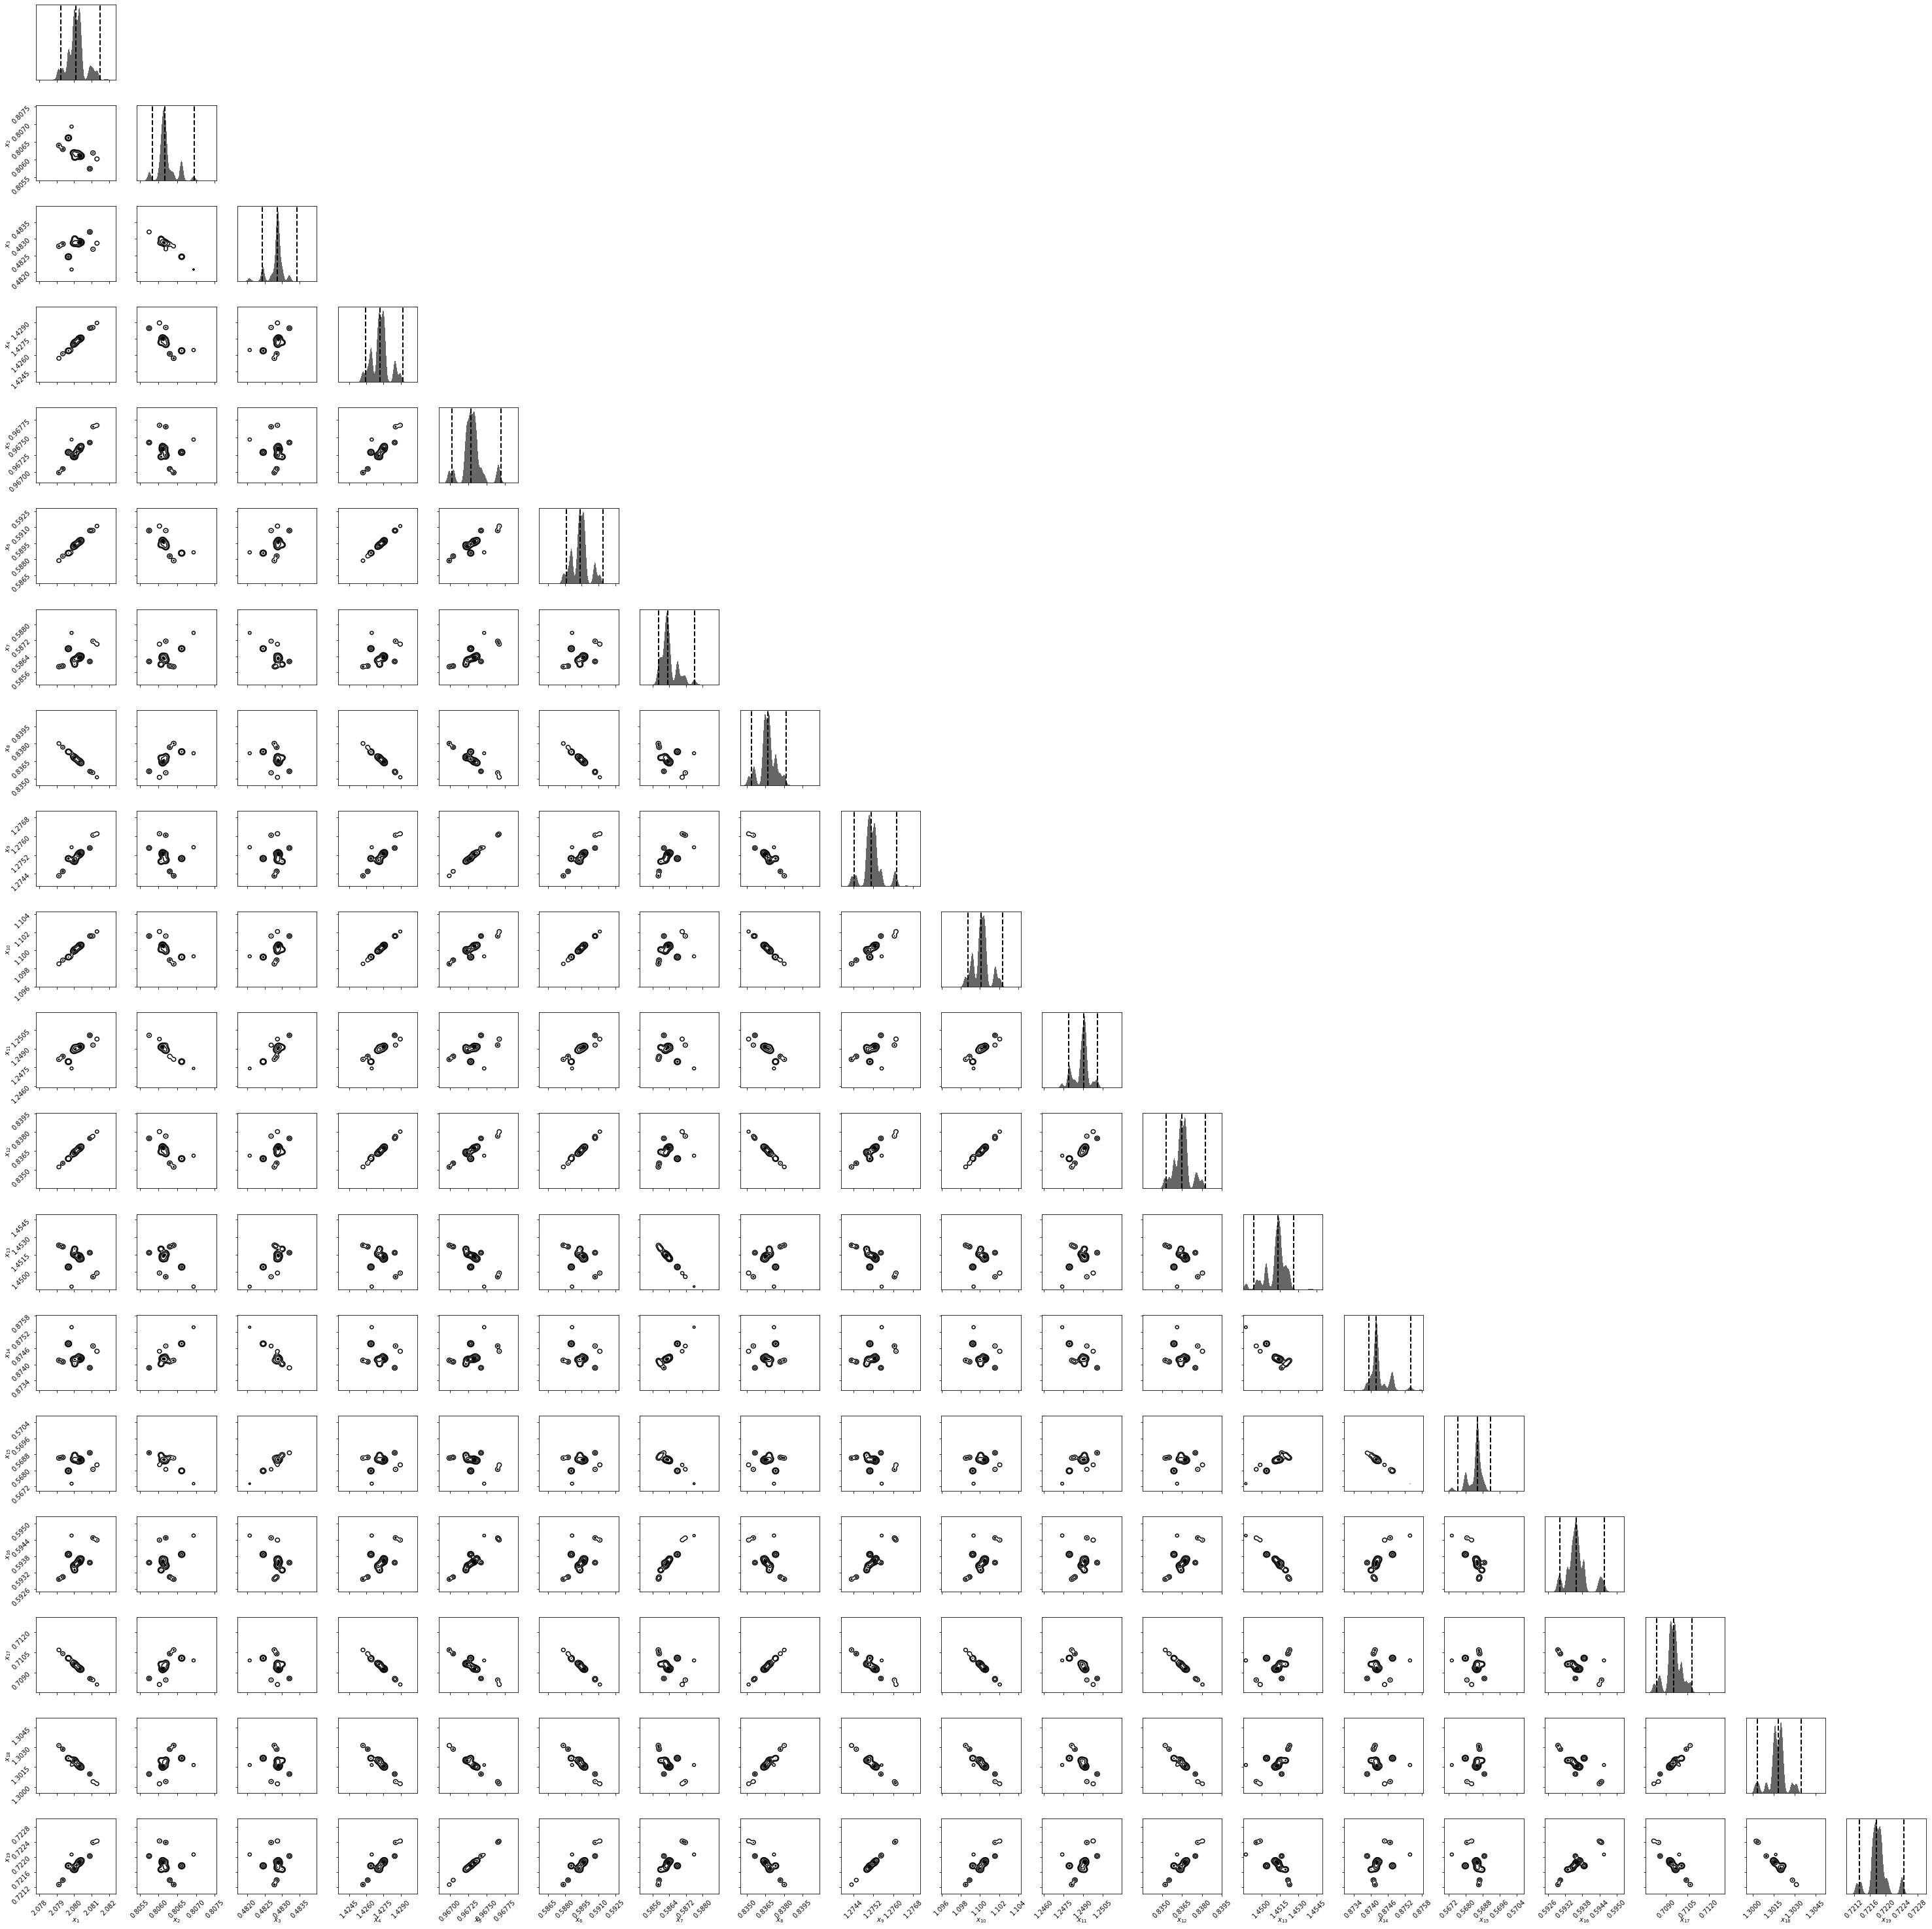

In [108]:
util.dyplot(bresults)

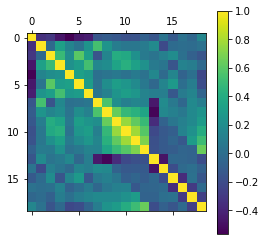

In [109]:
matshow(bijectors.get_log_stats(theta, post_bounds)['corr'])
colorbar();

[   9.46578248  559.19713573 1775.76032258 3396.07165188   30.00626581
   68.36851672  163.96412554]
[ 473.85864437 1296.46944818 1693.87813995 2721.56142432 2734.49189804
 1945.39836825] [294.16535016 450.91024775 159.31866122 876.03555732 947.438179
 179.40599503] -0.02801396221436485


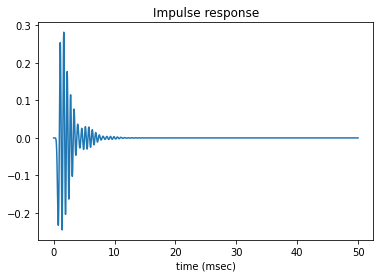

[  16.84044876  436.52874044 1596.88032592 2137.27012878   39.27486256
   61.91320069   72.87945947]
[ 369.25884401  901.9638635  1718.86473562 2426.84316768 2915.29972392
 3877.7883258 ] [300.67787949 530.6898053  283.16201965 452.37369049 705.65790357
 307.4825073 ] 0.4274182708110355


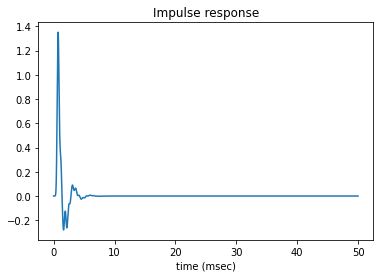

[  12.28936147  448.35974814 1640.44958247 2856.5846685    30.86926158
   59.84822926  136.56208691]
[ 471.53587864  659.60831966 1742.97639855 1721.58064391 1991.18588972
 1950.04309032] [ 186.95560646  621.27630235  345.45100911 1308.16564918  659.88895528
  277.86621565] 0.09736165564371634


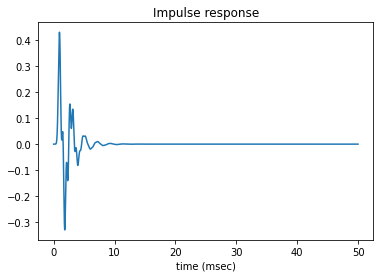

[   9.03713504  434.14073064 1219.99408686 2438.39892208   33.07184229
   51.28899404  102.72732413]
[ 573.83677322  545.80711521  690.07708468 1214.67613178 2340.87014395
 2776.10152501] [ 148.95915441 1103.69974456  246.33247673  461.05690885  589.00274237
  858.16499151] 0.13483553322690384


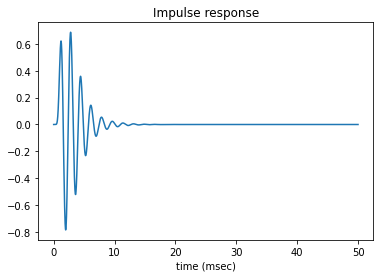

[   5.60374344  569.94496315 1764.61240787 2572.64681039   45.58670506
   52.152003    109.14759554]
[ 347.12849958  483.39776343 1447.1877545  2306.17266432 2188.7825101
 2368.25183437] [228.64533067 686.5654165  329.87915264 937.07390025 142.92965924
 237.44705629] -0.017716992524836682


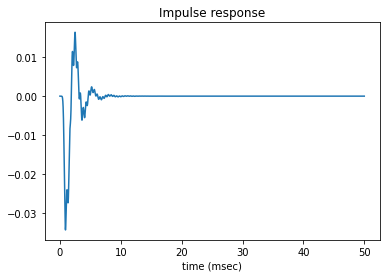

[   6.29539596  468.31687415 2001.13999367 3247.95959889   33.87762254
   71.29796808  136.69356829]
[ 343.16162792  549.34730949 2181.02441486 1931.56422181 2368.99583775
 1775.67202424] [ 421.8717458   522.94565471  126.45328416 1048.08387971 1178.81986488
  112.46552058] 0.22376061247099643


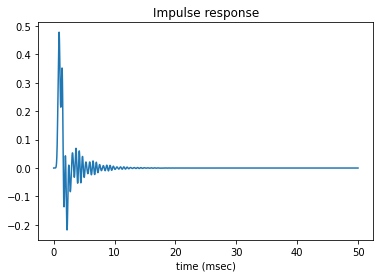

[   7.01744201  568.58718882 1492.497509   2691.22780695   31.99922483
   52.62563961   96.69677132]
[ 647.80489612  923.70796387 1336.79090139 1545.64615976 2853.24599178
 3660.07883306] [ 110.17085411 1082.6825619   356.06022264  645.34938457  387.39237975
  997.19726895] 0.10305215642484432


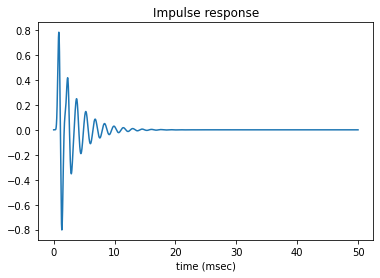

[2.18713429e+00 7.07640003e+02 1.75219542e+03 3.31819415e+03
 7.85746473e+01 1.04401374e+02 1.12595518e+02]
[ 659.30526544 1407.75370745 1944.39413349 2584.76919127 2732.92150376
 4132.70152667] [ 185.57851351  384.31941795  312.66300957 1499.93476218  701.09149699
  130.97446219] -0.1437606732841341


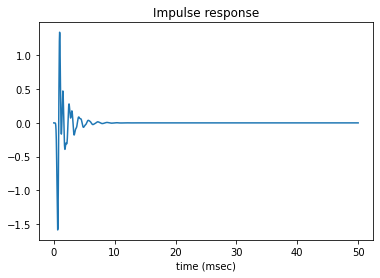

[   6.8885892   469.68275233 1324.29492644 2011.54664837   45.48692959
   51.90223595   96.71917468]
[ 496.53208783 1629.66590745 1719.30800436 1664.47271854 2777.38894069
 3062.92329222] [  83.66894466 1152.9898716   365.28023852  955.35995483 2762.56745638
  159.03345679] 0.10467514770037682


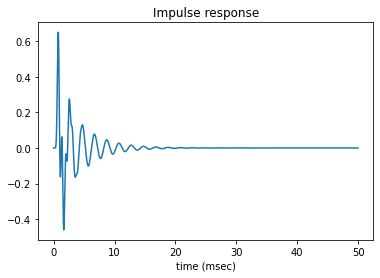

[   3.94226153  684.31834404 1422.35221339 2782.63264896   45.47801626
   47.08750075  124.08262916]
[ 482.3740527   721.5018499  1013.00227409 1636.98845902 3066.89402367
 4323.52227596] [ 805.90085288  269.33575246  211.41580606  143.8169843   875.42672125
 1024.50334286] 0.26669008345162964


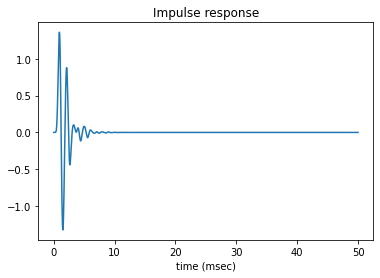

In [110]:
for i in range(10):
    sample = b.forward(randn(7 + 2*Kpost))
    TFB = sample[:7]
    print(TFB)
    x, y = np.split(sample[7:], 2)
    g = allpole.g_prior_ppf(rand(), x, y)
    print(x, y, g)
    
    t, dt = linspace(0, 50, 100000, retstep=True) # msec
    h = allpole.impulse_response(t, x, y, g)
    plot(t, h)
    title("Impulse response")
    xlabel("time (msec)")
    show()

1 -33.20245277862253 [1060.] [197.95978698]


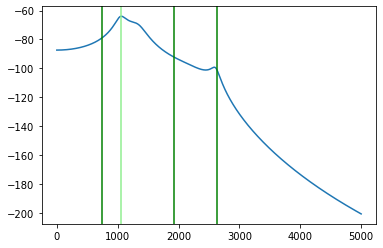

In [124]:
for i in range(1):
    sample = b.forward(randn(7 + 2*Kpost))
    TFB = sample[:7]
    F_true = TFB[1:4]
    x, y = np.split(sample[7:], 2)
    g = allpole.g_prior_ppf(rand(), x, y)

    f = constants.spectrum_frequencies()
    power = allpole.transfer_function_power_dB(f, x, y, g)

    plot(f, power + i*30, label="our implementation")
    
    nopeaks = spectrum.number_of_peaks(f, power)
    F, B = spectrum.get_formants_from_spectrum(f, power)
    
    print(nopeaks, spectrum.fit_tilt(f, power), F, B)
    for Fi in F_true: axvline(Fi, color="green")
    for Fi in F: axvline(Fi, color="lightgreen")

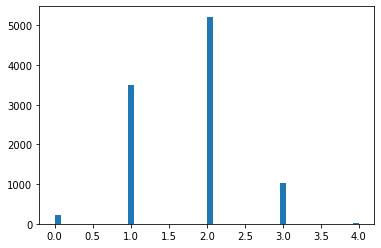

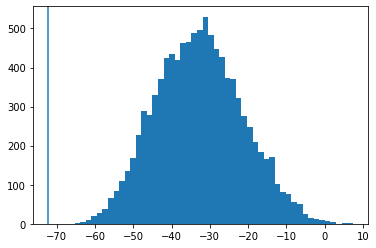

In [112]:
nopeaks = []
tilts = []

for i in range(10000):
    sample = b.forward(randn(7 + 2*Kpost))
    TFB = sample[:7]
    x, y = np.split(sample[7:], 2)

    f = constants.spectrum_frequencies()
    power = allpole.transfer_function_power_dB(f, x, y, 1.)
    
    F, B = spectrum.get_formants_from_spectrum(f, power)
    nopeaks += [len(F)]
    tilts += [spectrum.fit_tilt(f, power)]

hist(nopeaks, bins=50);
show()
hist(tilts, bins=50);
axvline(allpole.analytical_tilt(Kpost))